In [2]:
# Handle necessary imports
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
%matplotlib inline

# Load dataset
train = pd.read_csv('/Users/liuce/Downloads/we_data/train.csv')
test = pd.read_csv('/Users/liuce/Downloads/we_data/test.csv')
validation = pd.read_csv('/Users/liuce/Downloads/we_data/validation.csv')

In [3]:
from sklearn.linear_model import LogisticRegression
import time

In [4]:
# Negative sampling to fix imbalance
def negsample(data, ratio=1):
    conv = data[data.click == 1]
    oth = data[data.click == 0].sample(n=ratio*len(conv))
    return pd.concat([conv, oth]).sample(frac=1) #shuffle data

# neg_sam_train = negsample(train)
# neg_sam_val = negsample(validation)

# y_train_sampled = neg_sam_train.click
# X_train_sampled = neg_sam_train.drop('click', axis=1)

# y_val_sampled = neg_sam_val.click
# X_val_sampled = neg_sam_val.drop('click', axis=1)

# w = len(neg_sam_train)/ len(train)

# print("Negative sample ratio", w)

In [5]:
# Predict CTR
X_train = train.drop(['click','bidid','userid','IP','domain',
                'url','urlid','slotid','creative','bidprice','payprice','keypage'], axis=1)
y_train = train.click

X_val = validation.drop(['click','bidid','userid','IP','domain',
                'url','urlid','slotid','creative','bidprice','payprice','keypage'], axis=1)
y_val = validation.click
X_test = test.drop(['bidid','userid','IP','domain',
                'url','urlid','slotid','creative','keypage'], axis=1)

In [6]:
# Handling categorical data with one hot encoding

# 1. Encode day of week
def enc_day(X):
    X = pd.concat([X,pd.get_dummies(X.weekday,prefix='day')],axis=1)
    X = X.drop('weekday',axis=1)
    return X

# 2. Encode hours
def enc_hrs(X):
    X = pd.concat([X,pd.get_dummies(X.hour,prefix='hour')],axis=1)
    X = X.drop('hour',axis=1)
    return X

# Split user agent into 2 ~ OS and browser
def enc_OS_browser(X):
    df = pd.DataFrame(X.useragent.str.split('_',1).tolist(),
                                   columns = ['OS','browser'])
    X = pd.concat([X,df],axis=1)

    # 3. Encode OS
    X = pd.concat([X,pd.get_dummies(X.OS,prefix='OS')],axis=1)
    X = X.drop('OS',axis=1)

    # 4. Encode browser
    X = pd.concat([X,pd.get_dummies(X.browser,prefix='browser')],axis=1)
    X = X.drop('browser',axis=1)
    
    X = X.drop('useragent',axis=1)
    return X

In [7]:
# 5. Encode region
def enc_region(X):
    X = pd.concat([X,pd.get_dummies(X.region,prefix='region')],axis=1)
    X = X.drop('region',axis=1)
    return X

# 6. Encode adexchange
def enc_adexchange(X):
    X = pd.concat([X,pd.get_dummies(X.adexchange,prefix='adexchange')],axis=1)
    X = X.drop('adexchange',axis=1)
    return X

In [8]:
# 7. Encode slotwidth
def enc_slotwidth(X):
    X = pd.concat([X,pd.get_dummies(X.slotwidth,prefix='slotwidth')],axis=1)
    X = X.drop('slotwidth',axis=1)
    return X

# 8. Encode slotheight
def enc_slotheight(X):
    X = pd.concat([X,pd.get_dummies(X.slotheight,prefix='slotheight')],axis=1)
    X = X.drop('slotheight',axis=1)
    return X

In [9]:
# 9. Encode slotvisibility
def enc_slotvisibility(X):
    X = pd.concat([X,pd.get_dummies(X.slotvisibility,prefix='slotvisibility')],axis=1)
    X = X.drop('slotvisibility',axis=1)
    return X

# 10. Encode slotformat
def enc_slotformat(X):
    X = pd.concat([X,pd.get_dummies(X.slotformat,prefix='slotformat')],axis=1)
    X = X.drop('slotformat',axis=1)
    return X

# 11. Encode advertiser
def enc_advertiser(X):
    X = pd.concat([X,pd.get_dummies(X.advertiser,prefix='advertiser')],axis=1)
    X = X.drop('advertiser',axis=1)
    return X

In [10]:
# 12. Encoding slotprice into buckets
def enc_slotprice(X):
    bins = pd.DataFrame()
    bins['slotprice_bins'] = pd.cut(X.slotprice.values,5, labels=[1,2,3,4,5])

    X = pd.concat([X,bins],axis=1)
    X = pd.concat([X,pd.get_dummies(X.slotprice_bins,prefix='slotprice')],axis=1)

    X = X.drop('slotprice',axis=1)
    X = X.drop('slotprice_bins',axis=1)
    bins.pop('slotprice_bins')
    return X

In [11]:
# 13. Encoding user tags
def enc_usertag(X):
    a = pd.DataFrame(X.usertag.str.split(',').tolist())
    usertag_df = pd.DataFrame(a)
    usertag_df2 = pd.get_dummies(usertag_df,prefix='usertag')
    usertag_df2 = usertag_df2.groupby(usertag_df2.columns, axis=1).sum()
    X = pd.concat([X, usertag_df2], axis=1)
    X = X.drop('usertag', axis=1)
    return X

In [12]:
# 14. Encoding cities
def enc_city(X):
    X = pd.concat([X,pd.get_dummies(X.city,prefix='city')],axis=1)
    X = X.drop('city',axis=1)
    return X

In [13]:
start_encode = time.time()

def encode_labels(X):
    X = enc_day(X)
    X = enc_hrs(X)
    X = enc_OS_browser(X)
    X = enc_region(X)
    X = enc_adexchange(X)
    X = enc_slotwidth(X)
    X = enc_slotheight(X)
    X = enc_slotvisibility(X)
    X = enc_slotformat(X)
    X = enc_advertiser(X)
#     X = enc_city(X)
    X = enc_slotprice(X)
    return X

print('---Started Encoding---')
# one hot encode train and val
X_train = encode_labels(X_train)
X_val = encode_labels(X_val)
print("Encoding Finished in %s minutes" % round(((time.time() - start_encode)/60),2))

---Started Encoding---
Encoding Finished in 0.59 minutes


In [14]:
X_test = encode_labels(X_test)
X_test = enc_usertag(X_test)

In [27]:
X_test.columns[151:219]

Index(['usertag_10006', 'usertag_10024', 'usertag_10031', 'usertag_10048',
       'usertag_10052', 'usertag_10057', 'usertag_10059', 'usertag_10063',
       'usertag_10067', 'usertag_10074', 'usertag_10075', 'usertag_10076',
       'usertag_10077', 'usertag_10079', 'usertag_10083', 'usertag_10093',
       'usertag_10102', 'usertag_10110', 'usertag_10111', 'usertag_10114',
       'usertag_10115', 'usertag_10116', 'usertag_10117', 'usertag_10118',
       'usertag_10120', 'usertag_10123', 'usertag_10125', 'usertag_10126',
       'usertag_10127', 'usertag_10129', 'usertag_10130', 'usertag_10131',
       'usertag_10133', 'usertag_10138', 'usertag_10140', 'usertag_10142',
       'usertag_10145', 'usertag_10146', 'usertag_10147', 'usertag_10148',
       'usertag_10149', 'usertag_10684', 'usertag_11092', 'usertag_11278',
       'usertag_11379', 'usertag_11423', 'usertag_11512', 'usertag_11576',
       'usertag_11632', 'usertag_11680', 'usertag_11724', 'usertag_11944',
       'usertag_13042', '

In [20]:
X_test[:5]

,city,day_0,day_1,day_2,day_3,day_4,day_5,day_6,hour_0,hour_1,...,usertag_13874,usertag_14273,usertag_15398,usertag_16593,usertag_16617,usertag_16661,usertag_16706,usertag_16751,usertag_16753,usertag_null
0,159,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,34,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,245,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,35,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Very slow and mem heavy encoding
start_usertag = time.time()
print('---Encoding Train Usertag---')

X_train = enc_usertag(X_train)

print("Encoded Train Usertag in %s minutes" % round(((time.time() - start_usertag)/60),2))

In [26]:
start_usertag_val = time.time()
print('---Encoding Validation Usertag---')

X_val = enc_usertag(X_val)
print("Encoded Validation Usertag in %s minutes" % round(((time.time() - start_usertag_val)/60),2))

---Encoding Validation Usertag---
Encoded Validation Usertag in 0.29 minutes


In [23]:
train = pd.read_csv('/Users/liuce/Downloads/we_data/train_withTags.csv')
validation = pd.read_csv('/Users/liuce/Downloads/we_data/validation_withTags.csv')

In [28]:
width = len(train.columns)

In [31]:
tag_cols = train.columns[width - 68: width]

In [36]:
df_tags_train = train[tag_cols]
df_tags_train.columns = cols_

In [37]:
df_tags_validation = validation[tag_cols]
df_tags_validation.columns = cols_

In [25]:
cols = ['10006', '10024', '10031', '10048', '10052',
       '10057', '10059', '10063', '10067', '10074', '10075', '10076', '10077',
       '10079', '10083', '10093', '10102', '10110', '10111', '10114', '10115',
       '10116', '10117', '10118', '10120', '10123', '10125', '10126', '10127',
       '10129', '10130', '10131', '10133', '10138', '10140', '10142', '10145',
       '10146', '10147', '10148', '10149', '10684', '11092', '11278', '11379',
       '11423', '11512', '11576', '11632', '11680', '11724', '11944', '13042',
       '13403', '13496', '13678', '13776', '13800', '13866', '13874', '14273',
       '15398', '16593', '16617', '16661', '16706', '16751', '16753']
len(cols)

68

In [26]:
cols_ = ['usertag_10006', 'usertag_10024', 'usertag_10031',
       'usertag_10048', 'usertag_10052', 'usertag_10057', 'usertag_10059',
       'usertag_10063', 'usertag_10067', 'usertag_10074', 'usertag_10075',
       'usertag_10076', 'usertag_10077', 'usertag_10079', 'usertag_10083',
       'usertag_10093', 'usertag_10102', 'usertag_10110', 'usertag_10111',
       'usertag_10114', 'usertag_10115', 'usertag_10116', 'usertag_10117',
       'usertag_10118', 'usertag_10120', 'usertag_10123', 'usertag_10125',
       'usertag_10126', 'usertag_10127', 'usertag_10129', 'usertag_10130',
       'usertag_10131', 'usertag_10133', 'usertag_10138', 'usertag_10140',
       'usertag_10142', 'usertag_10145', 'usertag_10146', 'usertag_10147',
       'usertag_10148', 'usertag_10149', 'usertag_10684', 'usertag_11092',
       'usertag_11278', 'usertag_11379', 'usertag_11423', 'usertag_11512',
       'usertag_11576', 'usertag_11632', 'usertag_11680', 'usertag_11724',
       'usertag_11944', 'usertag_13042', 'usertag_13403', 'usertag_13496',
       'usertag_13678', 'usertag_13776', 'usertag_13800', 'usertag_13866',
       'usertag_13874', 'usertag_14273', 'usertag_15398', 'usertag_16593',
       'usertag_16617', 'usertag_16661', 'usertag_16706', 'usertag_16751',
       'usertag_16753']
len(cols_)

68

In [38]:
X_train = pd.concat([X_train, df_tags_train], axis=1)

In [41]:
X_val = pd.concat([X_val, df_tags_validation], axis=1)

In [63]:
X_train.shape

(2430981, 219)

In [64]:
X_val.shape

(303925, 219)

In [79]:
X_test.shape

(303375, 219)

In [54]:
X_train.columns

Index(['city', 'usertag', 'day_0', 'day_1', 'day_2', 'day_3', 'day_4', 'day_5',
       'day_6', 'hour_0',
       ...
       'usertag_13866', 'usertag_13874', 'usertag_14273', 'usertag_15398',
       'usertag_16593', 'usertag_16617', 'usertag_16661', 'usertag_16706',
       'usertag_16751', 'usertag_16753'],
      dtype='object', length=220)

In [76]:
X_test.columns

Index(['city', 'day_0', 'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6',
       'hour_0', 'hour_1',
       ...
       'usertag_13874', 'usertag_14273', 'usertag_15398', 'usertag_16593',
       'usertag_16617', 'usertag_16661', 'usertag_16706', 'usertag_16751',
       'usertag_16753', 'usertag_null'],
      dtype='object', length=220)

In [46]:
X_train.to_csv('kama_train.csv')
X_val.to_csv('kama_val.csv')
X_test.to_csv('kama_test.csv')

In [61]:
X_train.drop('usertag', axis=1, inplace=True)
X_val.drop('usertag', axis=1, inplace=True)


In [78]:
X_test.drop('usertag_null', axis=1, inplace=True)

# 1. pCTR estimation 
# Logistic Regression --> Said

In [ ]:
# Hyperparameter tuning
# Model ~ Logistic Regression
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.metrics import auc,roc_curve

def tune_logreg():
    params = {'C' :[0.001,0.01,0.1,1.0,10.0]}
    lr = LogisticRegression(class_weight='balanced')    
    strk = StratifiedKFold(3, random_state=2048, shuffle=True)
    
    gr = GridSearchCV(lr, params, scoring='roc_auc', cv=strk, verbose=3)
    gr.fit(X_train, y_train)
    return gr.cv_results_

# Switch to True to tune
if True:
    lr_results = tune_logreg()


In [ ]:
# Best params
min_idx = np.argmax(lr_results['mean_test_score'])
lr_results['params'][min_idx]

In [146]:
tuning_lr_df = pd.DataFrame(lr_results)
tuning_lr_df = tuning_lr_df[['rank_test_score','param_C','mean_fit_time','std_fit_time','mean_test_score','std_test_score']]
tuning_lr_df.columns = ['rank','C','mean time','std time','mean AUC','std AUC']
tuning_lr_df

,rank,C,mean time,std time,mean AUC,std AUC
0,1,0.001,60.332912,2.825690,0.829984,0.001177
1,2,0.01,117.853973,7.627416,0.829016,0.000698
2,3,0.1,177.978387,54.880737,0.826775,0.001130
3,4,1,318.417584,25.438356,0.825664,0.001370
4,5,10,543.256229,55.809014,0.825096,0.001132


In [80]:
# Fit the classification model and predict on val
# Uses balanced class weights to resolve data imbalance
clf_l2_LR = LogisticRegression(class_weight='balanced', C = 0.001)
y_pred = clf_l2_LR.fit(X_train, y_train).predict(X_val)

In [81]:
# Fit the classification model and predict on test
# Uses balanced class weights to resolve data imbalance
clf_l2_LR_test = LogisticRegression(class_weight='balanced', C = 0.001)
y_pred_test = clf_l2_LR_test.fit(X_train, y_train).predict(X_test)

In [82]:
# pCTR test Values
predprobs_test = clf_l2_LR_test.predict_proba(X_test)
pCTR_test = pd.DataFrame(predprobs_test)

In [85]:
import pickle
pickle.dump(clf_l2_LR, open('kama_lr.pickle.dat', "wb"))

In [86]:
# pCTR val Values
predprobs = clf_l2_LR.predict_proba(X_val)
pCTR = pd.DataFrame(predprobs)

In [87]:
# Before recalibration
pCTR[1][:5]

0    0.209687
1    0.129264
2    0.094812
3    0.161409
4    0.145902
Name: 1, dtype: float64

In [88]:
# re calibrated predictions
# q = p / (p + (1-p) / w

pred =[]
pred_test=[]

a = len(train) / 2 * np.bincount(train.click)
w = a[1] / a[0]

for p in pCTR[1]:
    pred.append( p / (p + ((1-p)/w)))

for p in pCTR_test[1]:
    pred_test.append( p / (p + ((1-p)/w)))

In [108]:
w

0.00073810672537489891

In [92]:
# Model AUC score
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve([click for click in validation.click], pred)
print('AUC accuracy:',metrics.auc(fpr, tpr))

AUC accuracy: 0.853957185063


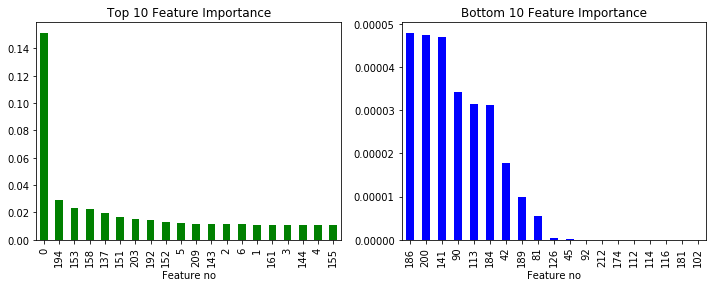

In [93]:
# Feature importances
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
importances = rf.fit(X_train, y_train).feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

important = list()
for f in range(X_train.shape[1]):
        important.append([indices[f],importances[indices[f]]])
        
important_df = pd.DataFrame(important)
important_df.columns = ['Feature no','Importance']
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
important_df[:20].plot(kind='bar', x='Feature no', color='g',ax=axes[0], title='Top 10 Feature Importance', legend=False)
important_df[200:].plot(kind='bar', x='Feature no', color='b',ax=axes[1], title='Bottom 10 Feature Importance', legend=False)

In [94]:
# Insignificant features
least_impdf = pd.DataFrame(important_df[214:])
least_impdf['Feature names'] = X_train.columns[[important_df[214:]['Feature no']]]
least_impdf[['Feature names','Importance']]

,Feature names,Importance
214,slotheight_100,0.0
215,slotheight_150,0.0
216,slotheight_230,0.0
217,usertag_10130,0.0
218,slotwidth_760,0.0


In [95]:
# Fit the classification model on feature subset 还不如原来。。。
X_train_1 = X_train.drop(X_train.columns[[important_df[214:]['Feature no']]], axis=1)
X_val_1 = X_val.drop(X_val.columns[[important_df[214:]['Feature no']]], axis=1)

clf_l2_LR_1 = LogisticRegression(class_weight='balanced', C = 0.001)
y_pred_1 = clf_l2_LR.fit(X_train_1, y_train).predict(X_val_1)
predprobs_1 = clf_l2_LR.predict_proba(X_val_1)
pCTR_1 = pd.DataFrame(predprobs_1)
pred_1 =[]

a = len(train) / 2 * np.bincount(train.click)
w = a[1] / a[0]

for p in pCTR_1[1]:
    pred_1.append( p / (p + ((1-p)/w)))
    
fpr_1, tpr_1, thresholds_1 = metrics.roc_curve([click for click in validation.click], pred_1)
print('AUC accuracy after feature selection:',metrics.auc(fpr_1, tpr_1))

AUC accuracy after feature selection: 0.853917593881


# SVM

In [132]:
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
svr_rbf = SVR(kernel='rbf',C = 1e3,max_iter = 3000)

In [133]:
svr_rbf.fit(x_train_array, y_train)

/Users/liuce/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=3000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


SVR(C=1000.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=3000, shrinking=True, tol=0.001, verbose=False)

In [134]:
import pickle
pickle.dump(svr_rbf, open("svr_rbf_model_kama.pickle.dat", "wb"))

In [ ]:
valBid = svr_rbf.predict(X_val)

In [ ]:
# Model AUC score
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve([click for click in validation.click], valBid)
print('AUC accuracy:',metrics.auc(fpr, tpr))
# AUC accuracy: 0.565963333969
